LINK DATASET : https://www.kaggle.com/datasets/andrewmvd/animal-faces/data

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d andrewmvd/animal-faces

100% 694M/696M [00:06<00:00, 199MB/s]
100% 696M/696M [00:06<00:00, 110MB/s]


In [ ]:
!unzip animal-faces.zip -d dataset_directory

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: dataset_directory/afhq/train/wild/flickr_wild_001378.jpg  
  inflating: dataset_directory/afhq/train/wild/flickr_wild_001379.jpg  
  inflating: dataset_directory/afhq/train/wild/flickr_wild_001380.jpg  
  inflating: dataset_directory/afhq/train/wild/flickr_wild_001381.jpg  
  inflating: dataset_directory/afhq/train/wild/flickr_wild_001382.jpg  
  inflating: dataset_directory/afhq/train/wild/flickr_wild_001384.jpg  
  inflating: dataset_directory/afhq/train/wild/flickr_wild_001385.jpg  
  inflating: dataset_directory/afhq/train/wild/flickr_wild_001386.jpg  
  inflating: dataset_directory/afhq/train/wild/flickr_wild_001387.jpg  
  inflating: dataset_directory/afhq/train/wild/flickr_wild_001388.jpg  
  inflating: dataset_directory/afhq/train/wild/flickr_wild_001389.jpg  
  inflating: dataset_directory/afhq/train/wild/flickr_wild_001390.jpg  
  inflating: dataset_directory/afhq/train/wild/flickr_wild_001391.jpg  
  inf

In [ ]:
!unzip animal-faces.zip -d cat_dog_wildlife

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: cat_dog_wildlife/afhq/train/wild/flickr_wild_001378.jpg  
  inflating: cat_dog_wildlife/afhq/train/wild/flickr_wild_001379.jpg  
  inflating: cat_dog_wildlife/afhq/train/wild/flickr_wild_001380.jpg  
  inflating: cat_dog_wildlife/afhq/train/wild/flickr_wild_001381.jpg  
  inflating: cat_dog_wildlife/afhq/train/wild/flickr_wild_001382.jpg  
  inflating: cat_dog_wildlife/afhq/train/wild/flickr_wild_001384.jpg  
  inflating: cat_dog_wildlife/afhq/train/wild/flickr_wild_001385.jpg  
  inflating: cat_dog_wildlife/afhq/train/wild/flickr_wild_001386.jpg  
  inflating: cat_dog_wildlife/afhq/train/wild/flickr_wild_001387.jpg  
  inflating: cat_dog_wildlife/afhq/train/wild/flickr_wild_001388.jpg  
  inflating: cat_dog_wildlife/afhq/train/wild/flickr_wild_001389.jpg  
  inflating: cat_dog_wildlife/afhq/train/wild/flickr_wild_001390.jpg  
  inflating: cat_dog_wildlife/afhq/train/wild/flickr_wild_001391.jpg  
  inflating: cat_d

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [ ]:
path = '/content/cat_dog_wildlife/afhq/train'

In [ ]:
import os

In [ ]:
kategori = os.listdir(path)
kategori

['dog', 'wild', 'cat']

Mengatur path dataset menjadi 3 train, val, test

In [ ]:
train_dir = '/content/cat_dog_wildlife/afhq/train'
validation_dir = '/content/cat_dog_wildlife/afhq/train'
test_dir = '/content/cat_dog_wildlife/afhq/train'

Menggunakan ImageDataGenerator untuk memuat serta melakukan augmentasi pada data

In [28]:
# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [29]:
# No data augmentation for the validation and test sets
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

Split dataset menjadi train, val, dan test

Data Train

In [30]:
# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

Found 14630 images belonging to 3 classes.


Data Val

In [ ]:
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(64,64),
    # target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 14630 images belonging to 3 classes.


Data Test

In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    # target_size=(150, 150),
    target_size=(64,64),
    batch_size=32,
    class_mode='categorical'
)

Found 14630 images belonging to 3 classes.


Menggunakan pre-trained model VGG16

In [31]:
# Use VGG16 as a feature extractor
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

Arsitektur model

In [32]:
# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    Dense(3, activation='softmax')  # Change the output units to match the number of classes
])

In [33]:
# Define a custom learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9
)
optimizer = Adam(learning_rate=lr_schedule)

Mengkompilkasi model

In [34]:
# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


callbacks

In [37]:
# Define callbacks
from tensorflow.keras.callbacks import  ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=3)

Latih Model

In [36]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/10
458/458 [==============================] - 96s 202ms/step - loss: 0.6739 - accuracy: 0.7486 - val_loss: 0.3413 - val_accuracy: 0.8721 - lr: 9.5299e-05


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/10
458/458 [==============================] - 82s 179ms/step - loss: 0.5303 - accuracy: 0.8033 - val_loss: 0.3360 - val_accuracy: 0.8789 - lr: 9.0810e-05
Epoch 3/10
458/458 [==============================] - 81s 177ms/step - loss: 0.4813 - accuracy: 0.8208 - val_loss: 0.3610 - val_accuracy: 0.8685 - lr: 8.6532e-05
Epoch 4/10
458/458 [==============================] - 81s 177ms/step - loss: 0.4570 - accuracy: 0.8243 - val_loss: 0.2844 - val_accuracy: 0.8942 - lr: 8.2455e-05
Epoch 5/10
458/458 [==============================] - 81s 177ms/step - loss: 0.4393 - accuracy: 0.8290 - val_loss: 0.2883 - val_accuracy: 0.8930 - lr: 7.8571e-05
Epoch 6/10
458/458 [==============================] - 82s 180ms/step - loss: 0.4248 - accuracy: 0.8370 - val_loss: 0.2761 - val_accuracy: 0.8962 - lr: 7.4869e-05
Epoch 7/10
458/458 [==============================] - 84s 183ms/step - loss: 0.3991 - accuracy: 0.8465 - val_loss: 0.2752 - val_accuracy: 0.8969 - lr: 7.1342e-05
Epoch 8/10
458/458 [========

Evaluasi model

In [38]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Akurasi pada data test: {test_accuracy:.2f}')

458/458 [==============================] - 33s 71ms/step - loss: 0.2440 - accuracy: 0.9098
Akurasi pada data test: 0.91


Membuat grafik pergerakan metrik Accuracy dan Loss terhadap epoch pada Training dan Validation

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

Grafik Accuracy

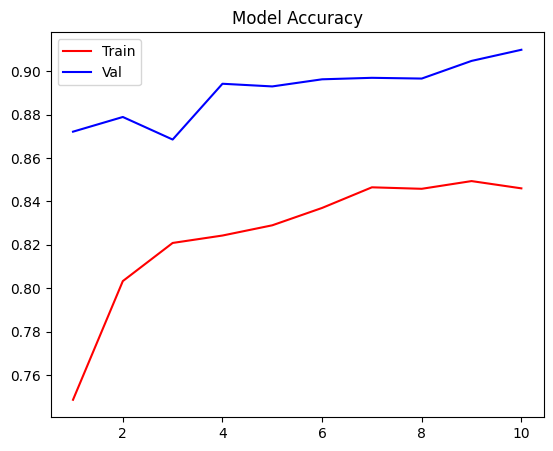

In [40]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Train')
plt.plot(epochs, val_acc, 'b', label='Val')
plt.title('Model Accuracy')
plt.legend()

Grafik Loss

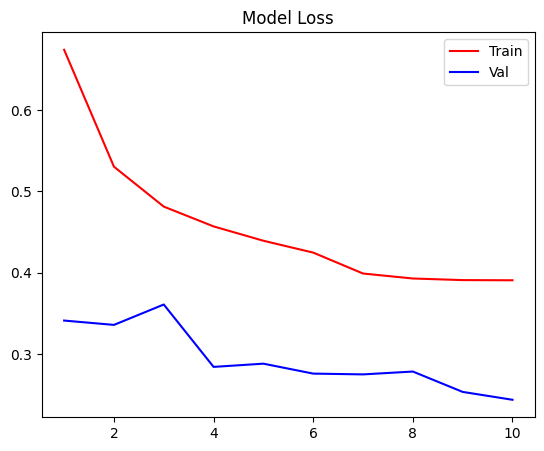

In [41]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Train')
plt.plot(epochs, val_loss, 'b', label='Val')
plt.title('Model Loss')
plt.legend()

plt.show()

